In [2]:
import operator
import os
import warnings
from os import listdir
from os.path import isfile, join

import matplotlib.pylab as plt
from PIL import Image
from pyshtools.legendre import legendre
from scipy.optimize import minimize
from scipy.special import eval_gegenbauer

from lib3 import *
from parameters import *

warnings.filterwarnings("ignore")
import mpmath as mp
from enum import Enum
from time import sleep
from scipy.optimize import curve_fit
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.special import sici, sinc

def get_dl(fcolors, nside, beam_arc_min=5):
    cl_SMICA = hp.anafast(fcolors)
    ell = np.arange(len(cl_SMICA))
    pl = hp.sphtfunc.pixwin(nside=nside)
    dl_SMICA = cl_SMICA / (B_l(beam_arc_min, ell) ** 2 * pl ** 2)
    dl_SMICA = (ell * (ell + 1) * dl_SMICA / (2 * math.pi))
    return cl_SMICA, dl_SMICA, ell


class fitClass:
    def __init__(self):
        self.t = []
        self.smica = []
        self.white_noise=[]
        self.func=self.correctWN
        self.n = 6

    def six_peaks(self, ell, *parkguess):
        'function of two overlapping peaks'
        p = np.zeros([1, len(ell)])
        # gamma = parkguess[-1:][0]
        for i in np.arange(0, self.n * 3, 3):
            a0 = parkguess[i + 0] # peak height
            a1 = parkguess[i + 1] # Gaussian Center
            a2 = parkguess[i + 2] # std of gaussian
            # gamma = parkguess[i + 3]  # std of gaussian
            p += self.fitfun(ell, a0, a1, a2)
        return p[0]

    def fitfun(self, x, a0, a1, a2):
        return a0 * norm.pdf(x, loc=a1, scale=a2)

    def correctWN(self,x):
        return x[0] * np.exp(x[1] * self.t) * self.white_noise
        # return x[0]+x[1]*np.exp(x[2]*self.t)*self.white_noise

    def sins_quared(self,x):
        phase =  self.t/x[3]
        data_1D = x[0]*sici( phase )[0]
        box_kernel = Gaussian1DKernel(x[1])
        smoothed_data_box = convolve(data_1D, box_kernel) * np.exp(x[2] * phase)
        return smoothed_data_box

    def fitGN(self,x):
        err = np.sum((self.smica-self.func(x))**4*1E20)
        return err

    def optimizeme(self, x0):
        x00 = minimize(self.fitGN, x0,
                       method='nelder-mead', options={'xatol': 1e-18, 'disp': True,'maxiter':10000})
        err = x00.fun
        xx0 = x00.x
        return xx0, err

    def plotme(self,x0, ymax =None):
        plt.figure()
        plt.plot(self.t, self.smica)
        plt.plot(self.t, self.func(x0), 'r-')
        # plt.xlim([0, 2500])
        # plt.ylim([0, ymax])
        plt.show()

    def plotmeSix(self,x0):
        plt.plot(self.t, self.smica, self.t, self.func(x0))
        plt.xlim([0,None])
        plt.ylim([0,np.max(self.smica)])
        plt.show()





params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large'}
plt.rcParams.update(params)


class Color(Enum):
    MINIMIZEPOSITION = 1
    FINDNEIGHBORHOOD = 2
    EVALUATE_DF_AT_POSITION = 3
    FINDBESTFORKRANGE = 4
    OPTIMIZE_SPECTRUM = 5
    CREATE_GAUSSIAN_BACKGROUND = 6
    WORK_86_128 = 7
    OPTIMIZE_SMICA_BACKGROUND = 8


def get_chopped_range(lmax, n=20, lmin=1):
    llist = sorted(list({int(np.round(x, 0)) for x in np.linspace(lmin, lmax, n)}))
    return llist


def sinxx(xx):
    y = np.zeros(xx.shape)
    for i, x in enumerate(xx):
        if x == 0:
            y[i] = 1.0
        else:
            y[i] = np.sin(x) / x
    return y


def optimzeSpectraC(df, x0, opt=False, kkk=None):
    def erroC(x, df):
        k = df.k - 2
        dk = x[0] * k + x[1] * k ** 2 + x[2] * k ** 3
        dl = x[3] * df.l + x[4] * df.l ** 2
        dm = x[5] * np.abs(df.m) + x[6] * df.m ** 2
        df["population"] = x[7] + dk + dl + dm
        dfG = pd.DataFrame(df.groupby(['k', "l"])["CL", "population"].apply(lambda x: x.astype(float).mean()),
                           columns=["CL", "population"])
        dfG["CL"] /= dfG["CL"].max()
        err = np.sum((dfG.population - dfG.CL) ** 2)
        print(err)
        return err

    if opt:
        if kkk:
            df = df[(df.k == kkk[0]) * (df.l == kkk[1])]
        xout = minimize(erroC, x0, args=(df), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
        print("errC", xout.fun, xout.x)
        return xout.x, df
    else:
        x = x0
    ##########################################################
    if kkk:
        df = df[(df.k == kkk[0]) * (df.l == kkk[1])]
        plt.plot(df.m, df.coeff)
        plt.show()
    k = df.k - 2
    dk = x[0] * k + x[1] * k ** 2 + x[2] * k ** 3
    dl = x[3] * df.l + x[4] * df.l ** 2
    dm = x[5] * np.abs(df.m) + x[6] * df.m ** 2
    df["population"] = x[7] + dk + dl + dm
    dfG = pd.DataFrame(df.groupby(['k', "l"])["CL", "population"].apply(lambda x: x.astype(float).mean()),
                       columns=["CL", "population"])
    dfG["CL"] /= dfG["CL"].max()
    dfG["difference"] = (dfG.CL - dfG.population) / dfG.population
    dfG["zero"] = 0.0
    dfG["one"] = 1.0
    ##########################################################
    ax = dfG.CL.plot(legend=False)
    # dfG.population.plot( ax=ax)

    plt.xlabel('Hyperspherical Harmonic k')
    plt.title('Power Spectrum C')
    plt.ylabel("Hyperspherical Harmonic Mode Population")
    # plt.ylim(0, 2)
    plt.show()


def plot_aitoff(fcolors, cmap=cm.RdBu_r):
    hp.mollview(fcolors.squeeze(), cmap=cmap)
    hp.graticule()
    plt.show()

def plot_aitoff_df(l, m, df, cmap=cm.RdBu_r):
    def plot_orth(fcolors):
        sigma = np.std(fcolors)
        hp.orthview(fcolors, min=-2 * sigma, max=2 * sigma, title='Raw WMAP data', unit=r'$\Delta$T (mK)')
        plt.show()

    def get_LM(l, m, df):
        if m >= 0:
            ind = (l + 1) * (l + 2) - l + m
            return df[0, ind, :]
        if m < 0:
            ind = (l + 1) * (l + 2) - l + m
            return df[1, ind, :]

    fcolors = get_LM(l, m, df)
    plot_aitoff(fcolors, cmap=cmap)
    plot_orth(fcolors)

def B_l(beam_arcmin, ls1):
    theta_fwhm = ((beam_arcmin / 60.0) / 180) * math.pi
    theta_s = theta_fwhm / (math.sqrt(8 * math.log(2)))
    return np.exp(-2 * (ls1 + 0.5) ** 2 * (math.sin(theta_s / 2.0)) ** 2)

def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

def chunks(lst, n, args=None):
    """Yield successive n-sized chunks from lst."""
    maxn = len(lst)
    for i in range(0, maxn, n):
        nextstep = i + n
        if nextstep > maxn:
            nextstep = maxn
        if args is not None:
            yield (i, args, lst[i:nextstep])
        else:
            yield (i, lst[i:nextstep])


def chg2ang(alpha):
    residue = alpha % (2 * np.pi)
    return int(residue * 180 / np.pi)

def newerr(x, SMICA_LR, newmap):
    newnewmap = SMICA_LR.squeeze() - x[1] * newmap.squeeze() - x[0]
    err = np.var(newnewmap)
    return err


def olderr(x, dl_SMICA, ell):
    # err = np.std(dl_SMICA- x[0]*np.sin(x[1]*ell)**2/ell**2+x[2]*ell**x[3])
    err = dl_SMICA - x[0] - x[1] * np.exp(ell ** x[2]) - x[3] * np.sin(ell * x[4]) ** 2 / (x[4] * ell) ** 2
    err = np.sum(err * err)
    print(err, x)
    return err


def functionG(a):
    l = a[0][0] - 1
    k = a[0][1] + l
    cosksi = a[1]
    A = np.array([eval_gegenbauer(1 + l, k - l, x) for x in cosksi])
    # print(a[0], "done")
    return a[0], A


class HYPER:
    def __init__(self, nside3D, sigma_smica, planck_IQU_SMICA, karray,
                 lambda_k=0.0, lambda_l=0.0, lambda_m=0.0, bandwidth=256,
                 loadpriorG=False, savePG=False, longG=False):
        self.G = pd.DataFrame()
        self.loadpriorG = loadpriorG
        self.savePG = savePG
        self.extra_G_keys = {}
        self.extra_P_keys = {}
        self.longG = longG
        self.nside3D = nside3D
        self.bandwidth = bandwidth
        self.df = np.zeros([1, 1])
        self.results = {}
        self.sigma_smica = sigma_smica
        self.xx, self.yy, self.zz = hp.pix2vec(nside=nside3D, ipix=np.arange(hp.nside2npix(nside3D)))
        self.k1 = min(karray)
        self.kmax = max(karray)
        self.karray = karray
        self.mypath = "./PG_data"
        self.G_filename = os.path.join(self.mypath, "G_{}_{}_{}_{}.npy".format(self.nside3D,
                                                                                  chg2ang(lambda_k),
                                                                                  chg2ang(lambda_l),
                                                                                  chg2ang(lambda_m)))
        self.P_filename = os.path.join(self.mypath, "P_{}_{}_{}_{}_".format(self.nside3D,
                                                                               chg2ang(lambda_k),
                                                                               chg2ang(lambda_l),
                                                                               chg2ang(lambda_m)))
        # self.G_filename = "./PG_data/G_64_492_495_709.npy"
        if loadpriorG:
            if os.path.exists(self.G_filename):
                print("loading from ", self.G_filename)
                self.G = pd.read_pickle(self.G_filename)
        self.sinksi = np.zeros([1, 1])
        self.cosksi = np.zeros([1, 1])
        self.phi = np.zeros([1, 1])
        self.x = np.zeros([1, 1])
        self.y = np.zeros([1, 1])
        self.z = np.zeros([1, 1])
        self.costheta = np.zeros([1,1])
        self.lambda_k, self.lambda_l, self.lambda_m = (lambda_k, lambda_l, lambda_m)
        self.SMICA = self.normalizeFColors(planck_IQU_SMICA, sigma_smica)
        self.SMICA_LR = self.SMICA
        self.newmap = np.zeros(self.SMICA.shape)
        self.change_SMICA_resolution(nside3D, doit=True, bandwidth=bandwidth)
        self.change_HSH_center(self.lambda_k, self.lambda_l, self.lambda_m, self.karray,
                               self.nside3D, loadpriorG=loadpriorG, doit=True, savePG=savePG)

    def change_SMICA_resolution(self, nside3D, doit=False, bandwidth=256):
        if (self.nside3D == nside3D) and not doit:
            return
        filename = "./img1/SMICA_{}_{}.png".format(nside3D, bandwidth)
        title = "SMICA_nside3D={}_{}".format(nside3D, bandwidth)
        self.SMICA_LR = self.change_resolution(self.SMICA, nside3D=nside3D, bandwidth=bandwidth,
                                               title=title, filename=filename,
                                               plotme=True, save=True)

    def factorMP(self, k, l, m):
        m = np.abs(m)
        a = (-1) ** m * np.sqrt((2 * l + 1) / (2 * np.pi) * mp.factorial(l - m) / mp.factorial(l + m))
        b = (-1) ** k * np.sqrt(
            2 * (k + 1) / np.pi * mp.factorial(k - l) / mp.factorial(k + l + 1) * 2 ** (2 * l) * mp.factorial(l) ** 2)
        c = float(a * b)
        return c

    def normalizeFColors(self, fcolors, sigma_smica):
        (mu, sigma) = norm.fit(fcolors)
        if sigma == 0.0:
            return fcolors
        return sigma_smica / sigma * (fcolors - mu)

    def getSpectralFiles(self, mypath):
        return [join(mypath, f) for f in sorted(listdir(mypath)) if isfile(join(mypath, f))]

    def creategiff(self, kmax, nside3D, mypath="./img1", prefix="aitoff_", filename="CMB"):
        giffiles = self.getSpectralFiles(mypath)
        giffiles = [x for x in giffiles if prefix in x]
        images = []
        for ff in giffiles:
            with Image.open(ff).convert("RGB") as img:
                images.append(img)
        fname = os.path.join(mypath, filename) + '_{}_{}.gif'.format(kmax, nside3D)
        images[0].save(fname, save_all=True, append_images=images[1:], optimize=False, duration=1000, loop=0)

    def creategiffMem(self, x):
        # err, prime, results, fig
        images = [y[3] for y in x]
        titles = [y[1] for y in x]
        errs = [y[0] for y in x]
        for i, xx in enumerate(images):
            (lk, ll, lm) = [x for x in titles[i]]
            err = errs[i]
            filename = "./img1/aitoff_{}_{}_{}_{}.png".format(kmax, chg2ang(lk), chg2ang(ll), chg2ang(lm))
            # draw the canvas, cache the render
            xx.seek(0)
            im = Image.open(xx)
            im.save(filename)

    def change_resolution(self, fcolors, nside3D=1024, filename=None,
                          title=None, save=False, plotme=None, bandwidth=256):
        # noinspection PyUnresolvedReferences
        SMICA_alms = hp.map2alm(fcolors, lmax=bandwidth)
        fcolors = hp.alm2map(SMICA_alms, nside=nside3D)
        (mu, sigma) = norm.fit(fcolors)
        if sigma != 0.0:
            fcolors = (fcolors - mu) / sigma * self.sigma_smica
        fcolors = np.expand_dims(fcolors, axis=1)
        self.plot_aitoff(fcolors.squeeze(), kk=0, ll=0, mm=0, err=0, filename=filename, title=title, save=save,
                         plotme=plotme)
        return fcolors

    def plotHistogram(self, fcolors, nside3D, kmax, plotme=False):
        (mu, sigma) = norm.fit(fcolors)
        n, bins, patch = plt.hist(fcolors, 600, density=1, facecolor="r", alpha=0.25)
        y = norm.pdf(bins, mu, sigma)
        plt.plot(bins, y)
        plt.xlim(mu - 4 * sigma, mu + 4 * sigma)
        plt.xlabel("Temperature/K")
        plt.ylabel("Frequency")
        plt.title(r"Histogram {}_{} HU Modeling of Planck SMICA Map ".format(kmax, nside3D), y=1.08)
        plt.savefig("./img1/Histogram_{}_{}.png".format(kmax, nside3D), dpi=300)
        if plotme:
            plt.show()

    def plot_aitoff(self, fcolors, kk, ll, mm, err, filename=None, title=None, plotme=False, save=False, nosigma=True):
        # noinspection PyUnresolvedReferences
        plt.clf()
        if title is None:
            title = "{}_{}_{}_{}".format(kmax, chg2ang(kk), chg2ang(ll), chg2ang(mm))

        f = plt.figure()
        if nosigma:
            hp.mollview(fcolors.squeeze(), title=title, min=-2 * self.sigma_smica,
                        max=2 * self.sigma_smica, unit="K", cmap=cm.RdBu_r)
        else:
            mu, sigma = norm.fit(fcolors.squeeze())
            hp.mollview(fcolors.squeeze(), title=title, min=mu - 2 * sigma,
                        max=mu + 2 * sigma, unit="K", cmap=cm.RdBu_r)
        hp.graticule()
        if save:
            plt.savefig(filename, format='png')
        if plotme:
            plt.show()
        f.clear()
        plt.close(f)

    def plot_Single_CL_From_Image(self, fcolors, nside, ymin=1E-6, ymax=1, xmax=300, log=False):
        cl_SMICA, dl_SMICA, ell = self.get_dl(fcolors, nside)
        dl_SMICA = dl_SMICA / np.max(dl_SMICA)
        fig = plt.figure(figsize=[12, 12])
        ax = fig.add_subplot(111)
        ax.plot(ell, dl_SMICA)
        ax.set_xlabel("$ell(ell+1)C_ell/2\pi \, \,(\mu K^2)$")
        ax.set_ylabel('$\ell$')
        ax.set_title("Angular Power Spectra")
        ax.legend(loc="upper right")
        if log:
            ax.set_yscale("log")
        ax.set_xlim(1, xmax)
        ax.set_ylim(ymin, ymax)
        ax.grid()
        plt.show()
        return cl_SMICA, dl_SMICA, ell

    def plot_CL_From_Image(self, fcolors, nside, planck_theory_cl, xmax=3000, ymax=1.0):
        cl_SMICA, dl_SMICA, ell = self.get_dl(fcolors, nside)
        dl_SMICA = dl_SMICA / np.max(dl_SMICA)
        planck_theory_cl[:, 1] = planck_theory_cl[:, 1] / np.max(planck_theory_cl[10:3000, 1])
        fig = plt.figure(figsize=[12, 12])
        ax = fig.add_subplot(111)
        ax.plot(planck_theory_cl[:, 0], planck_theory_cl[:, 1])
        ax1 = plt.twinx(ax)
        ax1.plot(ell, dl_SMICA)
        ax.set_xlabel("$ell(ell+1)C_ell/2\pi \, \,(\mu K^2)$")
        ax.set_ylabel('$\ell$')
        ax.set_title("Angular Power Spectra")
        ax.legend(loc="upper right")
        # ax1.set_yscale("log")
        ax.set_xlim(10, xmax)
        ax1.set_xlim(10, xmax)
        # ax1.set_ylim(1E-4, ymax)
        ax1.grid()
        plt.show()
        return cl_SMICA, dl_SMICA, ell

    def get_dl(self, fcolors, nside):
        cl_SMICA = hp.anafast(fcolors)
        ell = np.arange(len(cl_SMICA))
        pl = hp.sphtfunc.pixwin(nside=nside)
        # Deconvolve the beam and the pixel window function
        dl_SMICA = cl_SMICA / (B_l(10.0, ell) ** 2 * pl ** 2)
        dl_SMICA = (ell * (ell + 1) * dl_SMICA / (2 * math.pi))
        return cl_SMICA, dl_SMICA, ell

    def plot_ONLY_CL_From_Image(self, fcolors, nside, smica, nsidesmica, xmax=30):
        cl_SMICA, dl_SMICA_HU, ell = self.get_dl(fcolors.squeeze(), nside=nside)
        cl_SMICA, dl_SMICA, ell1 = self.get_dl(smica.squeeze(), nside=nsidesmica)
        dl_SMICA_HU /= np.max(dl_SMICA_HU[0:len(ell) // 2])
        dl_SMICA /= np.max(dl_SMICA[0:len(ell1) // 2])
        fig = plt.figure(figsize=[12, 12])
        ax = fig.add_subplot(111)
        ax.set_xlabel("$ell(ell+1)C_ell/2\pi \, \,(\mu K^2)$")
        line, = ax.plot(ell1, dl_SMICA)
        line.set_label('SMICA')
        ax1 = plt.twinx(ax)
        line1, = ax1.plot(ell, dl_SMICA_HU)
        line1.set_label('HU')
        ax1.set_ylabel('$\ell$')
        ax1.set_title("Angular Power Spectra {}_{}".format(self.kmax, self.nside3D))
        ax1.legend(loc="upper right")
        ax1.set_xlim(1, xmax)
        plt.ylim(1E-10, 1)
        ax1.grid()
        plt.savefig("./img1/AngularPowerSpectra_{}_{}.png".format(kmax, nside3D), dpi=300)
        plt.show()
        return dl_SMICA, dl_SMICA_HU, ell

    def plotSH(self, l, m, ll, lm, pp):
        fcolors = self.spherharmm(l, m, self.phi, pp)
        hp.mollview(fcolors.squeeze(), title="{}_{}_{}_{}".format(l, m, chg2ang(ll), chg2ang(lm)), cmap=cm.RdBu_r)
        hp.graticule()
        plt.show()
        return fcolors

    def plotNewMap(self, newmap, err, filename=None, title=None, plotme=False, save=False, nosigma=True):
        err0 = np.round(err, 3)
        if filename is None:
            filename = "./img1/aitoff_{}_{}_{}__{}_{}_{}.png".format(self.kmax, self.nside3D, err0,
                                                                     chg2ang(self.lambda_k),
                                                                     chg2ang(self.lambda_l),
                                                                     chg2ang(self.lambda_m))
        if title is None:
            title = "{}_{}_{}__{}_{}_{}".format(self.kmax, self.nside3D, err0, chg2ang(self.lambda_k),
                                                chg2ang(self.lambda_l),
                                                chg2ang(self.lambda_m))
        self.plot_aitoff(newmap, self.lambda_k, self.lambda_l,
                         self.lambda_m, err0, title=title, filename=filename, plotme=plotme, save=save, nosigma=nosigma)

    def calcStuff(self, alpha):
        err = 0.0
        results = 0.0
        prime = alpha[0]
        kmax = alpha[1]
        lk = prime[0]
        ll = prime[1]
        lm = prime[2]
        start_time = time()
        try:
            results, fcolors, err = self.project4D3d(kmax)
        except Exception as exception_object:
            print('Error with getting map for: {0}_{0}_{0}'.format(lk, ll, lm))
        stop_time = time()
        print(alpha, err)
        return [start_time, stop_time, err, prime, results]

    def mindict(self, test_dict):
        # Using min() + list comprehension + values()
        # Finding min value keys in dictionary
        temp = min(test_dict.values())
        res = [key for key in test_dict if test_dict[key] == temp]
        return res[0], test_dict[res[0]]

    def calcError(self, x, karray):
        t1 = datetime.now()
        self.change_HSH_center(x[0], x[1], x[2], karray, nside3D, loadpriorG=False, doit=True, savePG=False)
        _, _, err = self.project4D3d(karray)
        print(x, err, (datetime.now() - t1).microseconds)
        return err

    def calcErrorDF(self, x):
        err = np.sum((np.dot(x.T, self.df[:, 4:]) - self.SMICA_LR.squeeze()) ** 2) * 1E6
        return err

    def cleanup(self, mypath, prefix):
        filelist = [join(mypath, f) for f in sorted(listdir(mypath)) if
                    isfile(join(mypath, f)) and f.startswith(prefix)]
        for f in filelist:
            if os.path.exists(f):
                os.remove(f)
            else:
                print("The file does not exist")

    # def get_gegenbauerAsyn(self):
    #     number_of_workers = 10
    #     multiindex = pd.MultiIndex.from_tuples(self.extra_G_keys(), names=('k', 'l'))
    #     columns = list(np.arange(len(self.cosksi)))
    #     if len(self.extra_G_keys()) == 0:
    #         return
    #     extraG = pd.DataFrame(data=np.zeros([len(multiindex), len(columns)]), index=multiindex, columns=columns)
    #     extra_G_keys = ((x,self.cosksi) for x in self.extra_G_keys())
    #     with ProcessPoolExecutor(max_workers=number_of_workers) as executor:
    #         responses = executor.map(functionG, extra_G_keys)
    #     for response in responses:
    #         k = response[0][0]
    #         l = response[0][1]
    #         extraG.loc[(1+l,k-l),:] = response[1]
    #         print("transferred", k,l)
    #     return extraG

    def get_gegenbauerAsyn(self):
        multiindex = pd.MultiIndex.from_tuples(self.extra_G_keys(), names=('k', 'l'))
        columns = list(np.arange(len(self.cosksi)))
        if len(self.extra_G_keys()) == 0:
            return
        extraG = pd.DataFrame(data=np.zeros([len(multiindex), len(columns)]), index=multiindex, columns=columns)
        for key in self.extra_G_keys():
            a, extraG.loc[key, :] = functionG((key, self.cosksi))
            # print(a, "transferred")
        return extraG

    def change_HSH_center(self, lk, ll, lm, karray, nside, doit=False, loadpriorG=False, savePG=False):
        kmax = max(karray)
        if not doit:
            array_number_match = len(self.karray) == len(karray)
            if array_number_match:
                array_match = np.sum(self.karray == karray) != 0
            else:
                array_match = False
            if (self.lambda_k, self.lambda_l, self.lambda_m, self.kmax) == (lk, ll, lm, kmax) \
                    and array_number_match and array_match:
                return
        self.loadpriorG = loadpriorG
        self.savePG = savePG
        if not loadpriorG:
            self.G = pd.DataFrame()
        self.nside3D = nside
        self.xx, self.yy, self.zz = hp.pix2vec(nside=nside, ipix=np.arange(hp.nside2npix(nside)))
        self.lambda_k = lk
        self.lambda_l = ll
        self.lambda_m = lm
        self.z = self.zz + lk
        self.y = self.yy + ll
        self.x = self.xx + lm
        self.cosksi = np.cos(self.z)
        self.sinksi = np.sin(self.z)
        self.costheta = np.cos(self.y)
        self.phi = self.x
        G = {}
        listofk = sorted(karray)
        for k in listofk:
            for l in np.arange(1, k):
                if (1 + l, k - l) not in self.G.index:
                    G[1 + l, k - l] = 1
        if len(G) != 0:
            self.extra_G_keys = G.keys
            if self.G.shape[0] == 0:
                self.G = self.get_gegenbauerAsyn()
            else:
                self.G = pd.concat([self.G, self.get_gegenbauerAsyn()], axis=0)
        if self.savePG:
            self.G.to_pickle(self.G_filename)
        # kjump = 20
        # ibeginning=0
        # for i in np.arange(kjump, self.kmax, kjump):
        #     newPfile = self.P_filename + "{}.npy".format(i)
        #     if not os.path.exists(newPfile):
        #         pp = get_legendre((0,np.arange(ibeginning,i), self.costheta))[1].squeeze()
        #         np.save(newPfile,pp)
        #         ibeginning=i

    # def get_P(self, l, costheta):
    #     pp = np.zeros([0, kmax + 1, kmax + 1])
    #     lencos = len(costheta)
    #     number_of_workers = 10
    #     mychunks = chunks(costheta, lencos // number_of_workers, l)
    #     P = {}
    #     with ProcessPoolExecutor(max_workers=number_of_workers) as executor:
    #         responses = executor.map(get_legendre, mychunks)
    #     for response in responses:
    #         i = response[0]
    #         P[i] = response[1]
    #     for key in np.sort(list(P.keys())):
    #         pp = np.concatenate([pp, P[key]], axis=0)
    #     return pp

    def createGaussianBackground(self, x0, nside, delta, karray):
        xx, yy, zz = hp.pix2vec(nside=nside, ipix=np.arange(hp.nside2npix(nside)))
        x, y, z = tuple(map(operator.add, (xx, yy, zz), x0))
        cosksi = np.cos(z)
        sinksi = np.sin(z)
        costheta = np.cos(y)
        phi = x
        ############################################################
        ############################################################
        # random amplitudes
        wavefunction = np.zeros(xx.shape)
        t1 = datetime.now()
        print((datetime.now() - t1).seconds)
        df = np.array([len(karray), len(xx)])
        self.kmax = np.max(karray)
        self.calc_hyperharmnano0(karray)

        ############################################################
        return wavefunction

    def project4D3d_1(self, karray):
        self.kmax = np.max(karray)
        self.calc_hyperharmnano1(karray)
        C = np.dot(self.df[:, 4:], self.SMICA_LR)
        B = np.dot(self.df[:, 4:], self.df[:, 4:].T)
        results = np.linalg.solve(B, C)

        self.newmap = np.dot(results.T, self.df[:, 4:])
        mu, sigma = norm.fit(self.newmap)
        self.newmap = (self.newmap - mu) / sigma * self.sigma_smica
        err = (1.0 - np.correlate(self.newmap.squeeze(), self.SMICA_LR.squeeze()) * 1e4)[0]
        return results, self.newmap, err

    def project4D3d_0(self, karray):
        self.kmax = np.max(karray)
        self.calc_hyperharmnano2(karray)
        C = np.dot(self.df[:, 4:], self.SMICA_LR)
        B = np.dot(self.df[:, 4:], self.df[:, 4:].T)
        results = np.linalg.solve(B, C)

        self.newmap = np.dot(results.T, self.df[:, 4:])
        mu, sigma = norm.fit(self.newmap)
        self.newmap = (self.newmap - mu) / sigma * self.sigma_smica
        err = (1.0 - np.correlate(self.newmap.squeeze(), self.SMICA_LR.squeeze()) * 1e4)[0]
        return results, self.newmap, err

    def calc_hyperharmnano0(self, karray):
        nnn = 20
        kmax = np.max(karray)
        npoints = len(self.xx)
        jj = 0
        for k in karray:
            llist = sorted(list(set(int(np.round(kk, 0)) for kk in np.geomspace(1, k - 1, nnn))))
            for l in llist:
                jj += 1
        self.df = np.zeros([jj, 4 + npoints])
        pp = np.array([legendre(kmax - 1, x, csphase=-1) for x in self.costheta])
        jj = 0
        for k in karray:
            llist = sorted(list(set(int(np.round(kk, 0)) for kk in np.geomspace(1, k - 1, nnn))))
            jj = self.calc_hyperharmnano1(k, llist, pp, jj)

    def calc_hyperharmnano1(self, k, llist, pp, jj):
        ##############################################################
        ##############################################################
        newG = 0
        for ii, l in enumerate(llist):
            if (1 + l, k - l) not in self.G.index:
                aa, self.G[1 + l, k - l] = functionG(((1 + l, k - l), self.cosksi))
                newG += 1
            if (1 + l, k - l) not in self.G.index:
                print("missing", 1 + l, k - l)
            a = self.sinksi ** l * self.G.loc[(1 + l, k - l), :].values
            a1 = (-1) ** k * np.sqrt(2 * (k + 1) / np.pi * mp.factorial(k - l)
                                     * 2 ** (2 * l) * mp.factorial(l) ** 2 / mp.factorial(k + l + 1))
            a1 = float(a1)
            mlist = sorted(list(set(int(np.round(kk, 0)) for kk in np.linspace(-l, l, len(llist)))))
            b = np.zeros(self.xx.shape)
            for m in mlist:
                b += a * a1 * self.spherharmm(l, m, self.phi, pp[:, l, np.abs(m)])
            c = b.std()
            mu = b.mean()
            if c != 0:
                self.df[jj, 0] = k
                self.df[jj, 1] = l
                self.df[jj, 2] = 0
                self.df[jj, 3] = c
                self.df[jj, 4::] = b / c
                jj += 1
            else:
                print("failed ", k, l)
        print(jj, self.df.shape)
        if newG != 0:
            self.G.to_pickle(self.G_filename)
        return jj

    def calc_hyperharmnano2(self, karray):
        npoints = len(self.xx)
        nnn = 20
        G = {}
        listofk = sorted(karray)
        lmax = np.max(karray)
        pp = np.array([legendre(lmax, x, csphase=-1) for x in self.costheta])
        ##############################################################
        gg = 0
        for k in listofk:
            llist = sorted(list(set(int(np.round(kk, 0)) for kk in np.geomspace(1, k - 1, nnn))))
            for ii, l in enumerate(llist):
                mlist = sorted(list(set(int(np.round(kk, 0)) for kk in np.linspace(-l, l, nnn))))
                for m in mlist:
                    gg += 1
        self.df = np.zeros([gg, 4 + npoints])
        ##############################################################
        jj = 0
        for k in listofk:
            llist = sorted(list(set(int(np.round(kk, 0)) for kk in np.geomspace(1, k - 1, nnn))))
            for ii, l in enumerate(llist):
                if self.longG:
                    b = np.zeros(self.xx.shape)
                if (1 + l, k - l) not in self.G.index:
                    G[1 + l, k - l] = 1.0
                    print(k, l)
                    continue
                if (1 + l, k - l) not in self.G.index:
                    print("missing", 1 + l, k - l)
                a = self.sinksi ** l * self.G.loc[(1 + l, k - l), :].values
                a1 = (-1) ** k * np.sqrt(2 * (k + 1) / np.pi * mp.factorial(k - l)
                                         * 2 ** (2 * l) * mp.factorial(l) ** 2 / mp.factorial(k + l + 1))
                a1 = float(a1)
                mlist = sorted(list(set(int(np.round(kk, 0)) for kk in np.linspace(-l, l, nnn))))
                for m in mlist:
                    b = a * a1 * self.spherharmm(l, m, self.phi, pp[:, l, np.abs(m)])
                    c = b.std()
                    if c != 0:
                        self.df[jj, 0] = k
                        self.df[jj, 1] = l
                        self.df[jj, 2] = m
                        self.df[jj, 3] = c
                        self.df[jj, 4::] = b / c
                        jj += 1
                    else:
                        print("failed ", k, l, m)
        if len(G.keys()) != 0:
            self.extra_G_keys = G.keys
            print(G.keys())
            print("DO IT AGAIN")
        print(jj, gg, self.df.shape)

    def spherharmm(self, l, m, phi, pp):
        mm = np.abs(m)
        if m > 0:
            return pp * np.cos(mm * phi)
        if m == 0:
            return pp
        if m < 0:
            return pp * np.sin(mm * phi)

    def get_df_size(self, karray):
        npoints = len(self.xx)
        kmax = np.max(karray)
        jj = 0
        G = {}
        files = sorted([x for x in self.getSpectralFiles(self.mypath) if "/PG_data/P_{}_{}_{}_{}".format(self.nside3D,
                                                                                                         chg2ang(
                                                                                                             self.lambda_k),
                                                                                                         chg2ang(
                                                                                                             self.lambda_l),
                                                                                                         chg2ang(
                                                                                                             self.lambda_m)) in x])
        karray0 = [eval(x.replace(self.mypath, "").replace(".npy", "").split("_")[-1:][0]) for x in files]
        filesMap = {x: y for (x, y) in zip(karray0, files)}
        listofk = [x for x in sorted(list(filesMap.keys())) if x <= kmax]
        for k in listofk:
            pp = np.load(filesMap[k])
            llist = [np.count_nonzero(x, axis=0) for x in pp[0, :, :].squeeze()]
            pp = None
            llist = [x - 1 for x in llist if x < k + 1 and x > 1]
            for ii, l in enumerate(llist):
                if (1 + l, k - l) not in self.G.index:
                    G[1 + l, k - l] = 1.0
                for m in np.arange(-l, l + 1):
                    if not self.longG:
                        jj += 1
                if self.longG:
                    jj += 1
        self.df = np.zeros([jj, 4 + npoints])
        self.extra_G_keys = G.keys

    def plot_orth(self, fcolors):
        sigma = np.std(fcolors)
        hp.orthview(fcolors, min=-2 * sigma, max=2 * sigma, title='Raw WMAP data', unit=r'$\Delta$T (mK)')
        plt.show()

    def plot_aitoff_df(self, l, m, phi, pp=None, cmap=cm.RdBu_r):
        if pp is None:
            pp = np.array([legendre(l, x) for x in self.costheta])
        fcolors = self.spherharmm(l=l, m=m, phi=phi, pp=pp)
        sigma = np.std(fcolors)
        title = "{}_{}".format(l, m)
        hp.mollview(fcolors.squeeze(), title=title, min=-2 * sigma,
                    max=2 * sigma, unit="K", cmap=cm.RdBu_r)
        hp.graticule()
        self.plot_orth(fcolors)

    def optimizeNewMap(self, newmap0, SMICA_LR, xx0, nside3D, bandwidth, nosigma=True, mypath="./PG_data/"):
        newmap = xx0[1] * newmap0 + xx0[0]
        mu, sigma = norm.fit(newmap)
        newmap -= mu
        diffmap = SMICA_LR - newmap.squeeze()
        mu, sigma = norm.fit(diffmap)
        diffmap -= mu
        restoredmap = newmap + diffmap
        err = (1.0 - np.correlate(newmap, SMICA_LR) * 1e4)[0]
        return newmap, diffmap, restoredmap, err

    def matchSMICA(self, a, newmap):
        diffmap_1024 = a * self.SMICA.squeeze() + newmap * (1 - a)
        diffmap_1024 = (diffmap_1024 - np.mean(diffmap_1024)) / np.std(diffmap_1024) * self.sigma_smica
        myHyper.plotNewMap(diffmap_1024, err=0.0, plotme=True, title=str(a))

    def recalcXYZ(self,r):
        self.xx, self.yy, self.zz = hp.pix2vec(nside=self.nside3D, ipix=np.arange(hp.nside2npix(self.nside3D)))
        self.z = r*self.zz + self.lambda_k
        self.y = r*self.yy + self.lambda_l
        self.x = r*self.xx + self.lambda_m
        self.cosksi = np.cos(self.z)
        self.sinksi = np.sin(self.z)
        self.costheta = np.cos(self.y)
        self.phi = self.x
        self.P={}
        G = {}
        listofk = sorted(self.karray)
        for k in listofk:
            for l in np.arange(1, k):
                G[1 + l, k - l] = 1
        self.extra_G_keys=G.keys
        self.G = self.get_gegenbauerAsyn()

    def getCMBAtPos(self,lk,ll,lm, results):
        self.lambda_k=lk
        self.lambda_l=ll
        self.lambda_m=lm
        self.recalcXYZ(1.0)
        return self.getCMB(results).squeeze()

    def getCMBxyz(self, i, results):
        self.calc_hyperharmnano2(self.karray)
        self.newmap = np.dot(results.T, self.df[:, 4:])
        mu, sigma = norm.fit(self.newmap)
        self.newmap = (self.newmap - mu) / sigma * self.sigma_smica
        z=self.z - self.lambda_k
        y=self.y - self.lambda_l
        x=self.x - self.lambda_m
        df = np.zeros([len(x),5])
        df[:, 0] = i
        df[:,1]=x
        df[:, 2] = y
        df[:, 3] = z
        df[:, 4] = self.newmap
        return df, self.newmap

    def getUniverseMap(self, results, rr):
        map3D= np.zeros([0,5])
        fcolors={}
        for i, r in enumerate(rr):
            self.recalcXYZ(r)
            df, fcolors[i]=self.getCMBxyz(i, results)
            map3D = np.concatenate([map3D,df])
            print(i, r, map3D.shape)
        return map3D, fcolors

Earth Position [339.46, 341.1, 104.08]
evaluated at [4.92463563, 4.95336686, 0.8165214728204138]
48


0.0 180.0 -180.0 180.0


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

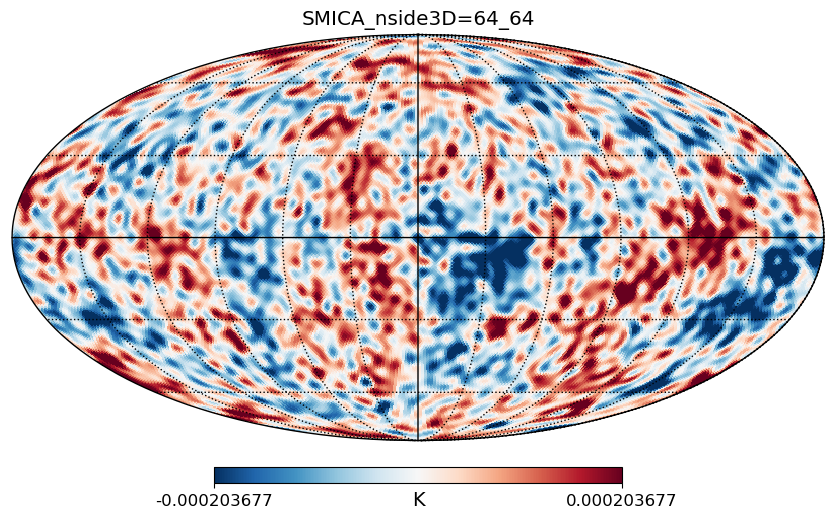

(2, 1) done
(2, 1) transferred
(2, 2) done
(2, 2) transferred
(3, 1) done
(3, 1) transferred
(2, 3) done
(2, 3) transferred
(3, 2) done
(3, 2) transferred
(4, 1) done
(4, 1) transferred
(2, 4) done
(2, 4) transferred
(3, 3) done
(3, 3) transferred
(4, 2) done
(4, 2) transferred
(5, 1) done
(5, 1) transferred
(2, 5) done
(2, 5) transferred
(3, 4) done
(3, 4) transferred
(4, 3) done
(4, 3) transferred
(5, 2) done
(5, 2) transferred
(6, 1) done
(6, 1) transferred
(2, 6) done
(2, 6) transferred
(3, 5) done
(3, 5) transferred
(4, 4) done
(4, 4) transferred
(5, 3) done
(5, 3) transferred
(6, 2) done
(6, 2) transferred
(7, 1) done
(7, 1) transferred
(2, 7) done
(2, 7) transferred
(3, 6) done
(3, 6) transferred
(4, 5) done
(4, 5) transferred
(5, 4) done
(5, 4) transferred
(6, 3) done
(6, 3) transferred
(7, 2) done
(7, 2) transferred
(8, 1) done
(8, 1) transferred
(2, 8) done
(2, 8) transferred
(3, 7) done
(3, 7) transferred
(4, 6) done
(4, 6) transferred
(5, 5) done
(5, 5) transferred
(6, 4) d

(23, 1) done
(23, 1) transferred
(2, 23) done
(2, 23) transferred
(3, 22) done
(3, 22) transferred
(4, 21) done
(4, 21) transferred
(5, 20) done
(5, 20) transferred
(6, 19) done
(6, 19) transferred
(7, 18) done
(7, 18) transferred
(8, 17) done
(8, 17) transferred
(9, 16) done
(9, 16) transferred
(10, 15) done
(10, 15) transferred
(11, 14) done
(11, 14) transferred
(12, 13) done
(12, 13) transferred
(13, 12) done
(13, 12) transferred
(14, 11) done
(14, 11) transferred
(15, 10) done
(15, 10) transferred
(16, 9) done
(16, 9) transferred
(17, 8) done
(17, 8) transferred
(18, 7) done
(18, 7) transferred
(19, 6) done
(19, 6) transferred
(20, 5) done
(20, 5) transferred
(21, 4) done
(21, 4) transferred
(22, 3) done
(22, 3) transferred
(23, 2) done
(23, 2) transferred
(24, 1) done
(24, 1) transferred
(2, 24) done
(2, 24) transferred
(3, 23) done
(3, 23) transferred
(4, 22) done
(4, 22) transferred
(5, 21) done
(5, 21) transferred
(6, 20) done
(6, 20) transferred
(7, 19) done
(7, 19) transferre

(32, 1) done
(32, 1) transferred
(2, 32) done
(2, 32) transferred
(3, 31) done
(3, 31) transferred
(4, 30) done
(4, 30) transferred
(5, 29) done
(5, 29) transferred
(6, 28) done
(6, 28) transferred
(7, 27) done
(7, 27) transferred
(8, 26) done
(8, 26) transferred
(9, 25) done
(9, 25) transferred
(10, 24) done
(10, 24) transferred
(11, 23) done
(11, 23) transferred
(12, 22) done
(12, 22) transferred
(13, 21) done
(13, 21) transferred
(14, 20) done
(14, 20) transferred
(15, 19) done
(15, 19) transferred
(16, 18) done
(16, 18) transferred
(17, 17) done
(17, 17) transferred
(18, 16) done
(18, 16) transferred
(19, 15) done
(19, 15) transferred
(20, 14) done
(20, 14) transferred
(21, 13) done
(21, 13) transferred
(22, 12) done
(22, 12) transferred
(23, 11) done
(23, 11) transferred
(24, 10) done
(24, 10) transferred
(25, 9) done
(25, 9) transferred
(26, 8) done
(26, 8) transferred
(27, 7) done
(27, 7) transferred
(28, 6) done
(28, 6) transferred
(29, 5) done
(29, 5) transferred
(30, 4) done


(35, 5) done
(35, 5) transferred
(36, 4) done
(36, 4) transferred
(37, 3) done
(37, 3) transferred
(38, 2) done
(38, 2) transferred
(39, 1) done
(39, 1) transferred
(2, 39) done
(2, 39) transferred
(3, 38) done
(3, 38) transferred
(4, 37) done
(4, 37) transferred
(5, 36) done
(5, 36) transferred
(6, 35) done
(6, 35) transferred
(7, 34) done
(7, 34) transferred
(8, 33) done
(8, 33) transferred
(9, 32) done
(9, 32) transferred
(10, 31) done
(10, 31) transferred
(11, 30) done
(11, 30) transferred
(12, 29) done
(12, 29) transferred
(13, 28) done
(13, 28) transferred
(14, 27) done
(14, 27) transferred
(15, 26) done
(15, 26) transferred
(16, 25) done
(16, 25) transferred
(17, 24) done
(17, 24) transferred
(18, 23) done
(18, 23) transferred
(19, 22) done
(19, 22) transferred
(20, 21) done
(20, 21) transferred
(21, 20) done
(21, 20) transferred
(22, 19) done
(22, 19) transferred
(23, 18) done
(23, 18) transferred
(24, 17) done
(24, 17) transferred
(25, 16) done
(25, 16) transferred
(26, 15) do

(32, 14) done
(32, 14) transferred
(33, 13) done
(33, 13) transferred
(34, 12) done
(34, 12) transferred
(35, 11) done
(35, 11) transferred
(36, 10) done
(36, 10) transferred
(37, 9) done
(37, 9) transferred
(38, 8) done
(38, 8) transferred
(39, 7) done
(39, 7) transferred
(40, 6) done
(40, 6) transferred
(41, 5) done
(41, 5) transferred
(42, 4) done
(42, 4) transferred
(43, 3) done
(43, 3) transferred
(44, 2) done
(44, 2) transferred
(45, 1) done
(45, 1) transferred
(2, 45) done
(2, 45) transferred
(3, 44) done
(3, 44) transferred
(4, 43) done
(4, 43) transferred
(5, 42) done
(5, 42) transferred
(6, 41) done
(6, 41) transferred
(7, 40) done
(7, 40) transferred
(8, 39) done
(8, 39) transferred
(9, 38) done
(9, 38) transferred
(10, 37) done
(10, 37) transferred
(11, 36) done
(11, 36) transferred
(12, 35) done
(12, 35) transferred
(13, 34) done
(13, 34) transferred
(14, 33) done
(14, 33) transferred
(15, 32) done
(15, 32) transferred
(16, 31) done
(16, 31) transferred
(17, 30) done
(17, 

In [2]:
myHyper = None
#################################################################
#################################################################
#################################################################
#################################################################
x0 = [4.92463563, 4.95336686, 0.8165214728204138]  # In degrees Earth Position [339.46, 341.1, 104.08]
# Earth Position
y0 = [np.round((xx + 1) / np.pi * 180, 2) for xx in x0]
print("Earth Position", y0)
# In degrees  [238.34, 63.23, 113.78]
# In degrees [120.0, 300.0, 240.0]
# todo = [Color.EVALUATE_DF_AT_POSITION, Color.OPTIMIZE_SMICA_BACKGROUND, Color.OPTIMIZE_SPECTRUM]
# todo = [Color.EVALUATE_DF_AT_POSITION]
# if Color.EVALUATE_DF_AT_POSITION in todo:
(lk, ll, lm) = x0

print("evaluated at {}".format(x0))
# Create karray
karray = list(np.arange(2, 50))
karray = np.array(sorted(list(set(karray)))).astype(int)

nside3D = 64
bandwidth = 64
# kmax=20064
# karray += sorted(list(set([int(k) for k in np.geomspace(49,kmax,20)])))
# karray = np.array(sorted(list(set(karray)))).astype(int)
print(len(karray))
kmax = max(karray)
#################################
if myHyper is None:
    myHyper = HYPER(nside3D, sigma_smica, planck_IQU_SMICA, karray,
                    lk, ll, lm, loadpriorG=False, savePG=False, bandwidth=bandwidth, longG=False)
#################################################################
results, newmap0, err = myHyper.project4D3d_0(karray)
#########################################################################

 

0.0 180.0 -180.0 180.0


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

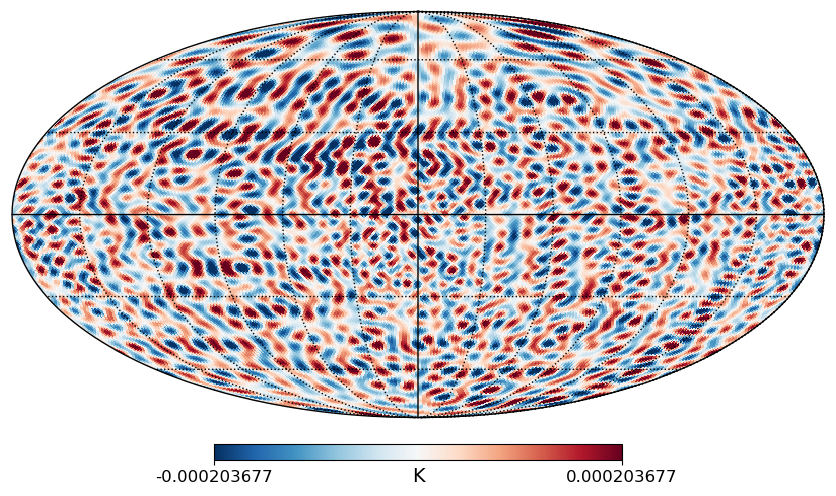

In [3]:
myHyper.plotNewMap(newmap0, err, filename="", title="", plotme=True, save=False)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 126


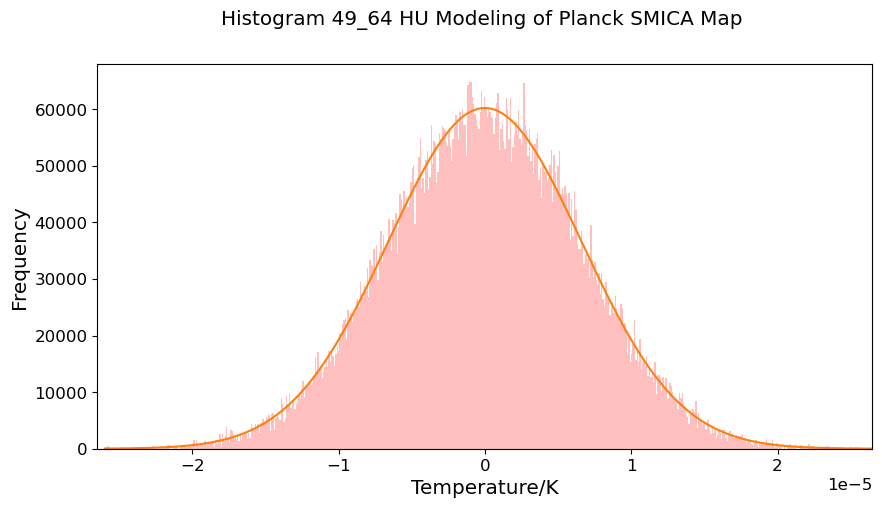

0.0 180.0 -180.0 180.0


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

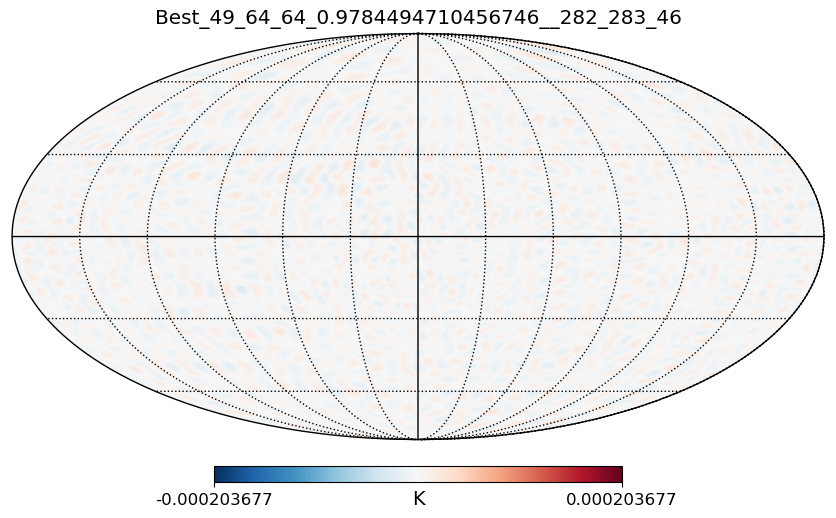

In [4]:
x01 = np.array([0.00161687, 0.31435231])
x00 = minimize(newerr, x01, args=(myHyper.SMICA_LR.squeeze(), newmap0.squeeze()),
               method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
err = x00.fun
xx0 = x00.x
newmap, diffmap, restoredmap, err = myHyper.optimizeNewMap(newmap0.squeeze(), myHyper.SMICA_LR.squeeze(),
                                                           xx0=xx0,
                                                           nside3D=nside3D, bandwidth=bandwidth, nosigma=True)
myHyper.plotHistogram(newmap.squeeze(), nside3D, kmax, plotme=True)
#################################################################
#################################################################
#################################################################
#########################################################################
filename = "./img1/SingleBest_{}_{}_{}__{}_{}_{}.png".format(kmax, nside3D, bandwidth, chg2ang(lk),
                                                             chg2ang(ll), chg2ang(lm))
title = "Best_{}_{}_{}_{}__{}_{}_{}".format(kmax, nside3D, bandwidth, err, chg2ang(lk),
                                            chg2ang(ll), chg2ang(lm))

myHyper.plotNewMap(newmap, err, filename=filename, title=title, plotme=True, save=True)


0.0 180.0 -180.0 180.0


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

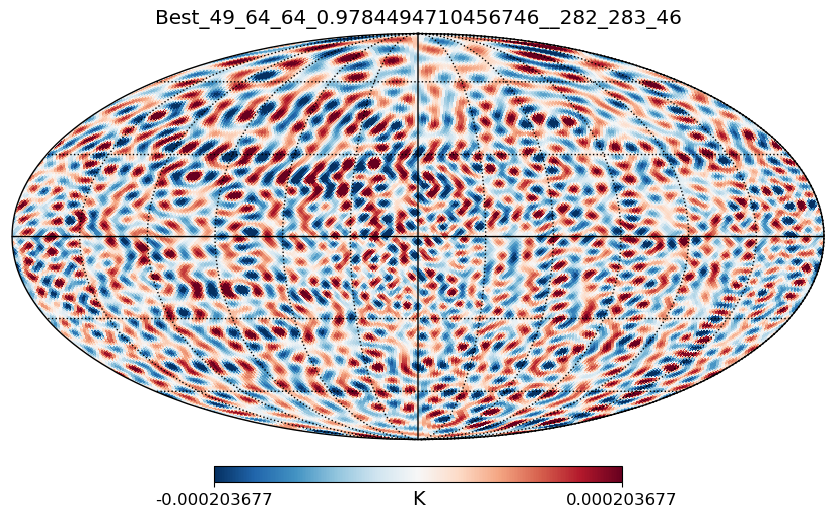

In [5]:
filename = "./img1/SingleBest_{}_{}_{}__{}_{}_{}.png".format(kmax, nside3D, bandwidth, chg2ang(lk),
                                                             chg2ang(ll), chg2ang(lm))
title = "Best_{}_{}_{}_{}__{}_{}_{}".format(kmax, nside3D, bandwidth, err, chg2ang(lk),
                                            chg2ang(ll), chg2ang(lm))

myHyper.plotNewMap(newmap0, err, filename=filename, title=title, plotme=True, save=True)


0.0 180.0 -180.0 180.0


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

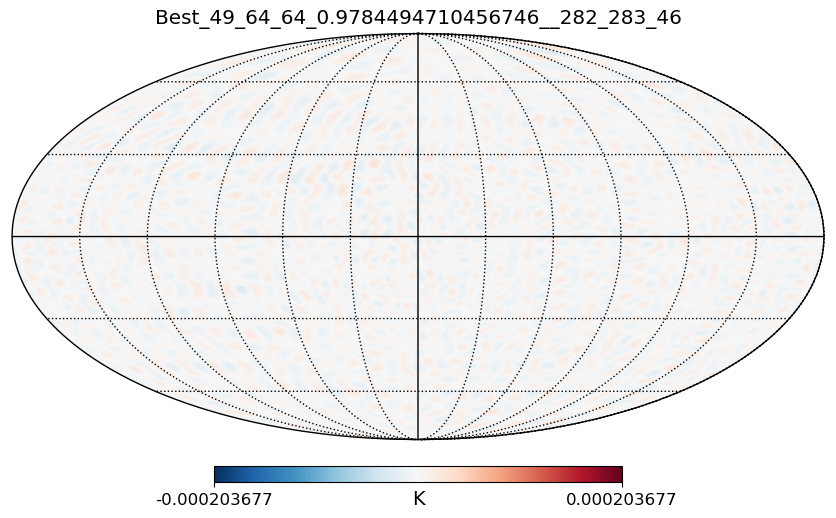

In [6]:
filename = "./img1/SingleBest_{}_{}_{}__{}_{}_{}.png".format(kmax, nside3D, bandwidth, chg2ang(lk),
                                                             chg2ang(ll), chg2ang(lm))
title = "Best_{}_{}_{}_{}__{}_{}_{}".format(kmax, nside3D, bandwidth, err, chg2ang(lk),
                                            chg2ang(ll), chg2ang(lm))

myHyper.plotNewMap(newmap, err, filename=filename, title=title, plotme=True, save=True)


In [7]:
rr = np.concatenate([np.linspace(0.01,0.99,99), np.linspace(0.999999990,1,10)])
map3D, all_fcolors = myHyper.getUniverseMap(results, rr)
for i, r in enumerate(rr): # np.linspace(0.01,1,100):
    if r < 0.99:
        r_round=np.round(r,2)
    else:
        r_round=r
    filename = "./universeorthoview/radius_{}.png".format(r_round)
    filenameG = "./universeorthoviewdual/globe_radius_{}.png".format(r_round)
    title = "Radius_{}".format(r_round)
    myHyper.plotNewMap(all_fcolors[i], err, filename=filename, title=title, plotme=True, save=True)
    stdd=all_fcolors[i].std()
    hp.orthview(all_fcolors[i].squeeze(), min=-3 * stdd, max=3 * stdd, half_sky=False, nest=False,
                cmap='magma',
                title = title, unit = r'$\Delta$T (mK)')
    plt.savefig(filenameG)
    plt.show()


KeyboardInterrupt: 

In [ ]:
myHyper.creategiff(kmax, nside3D, mypath="./universeorthoview", prefix="radius_", filename="CMB_Universe_Tomography")
myHyper.creategiff(kmax, nside3D, mypath="./universeorthoviewdual", prefix="globe_radius_",
                   filename="CMB_Universe_Dual_Tomography")

In [ ]:
np.savetxt("./img1/map3D.txt", map3D, delimiter=",")
np.save("./img1/all_fcolors.npy", all_fcolors)